In [177]:
import numpy as np
import torch
import torch.nn as nn
import collections
import pandas as pd
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

from argparse import Namespace

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

%matplotlib inline

IN TEXT EXAMPLES

In [178]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

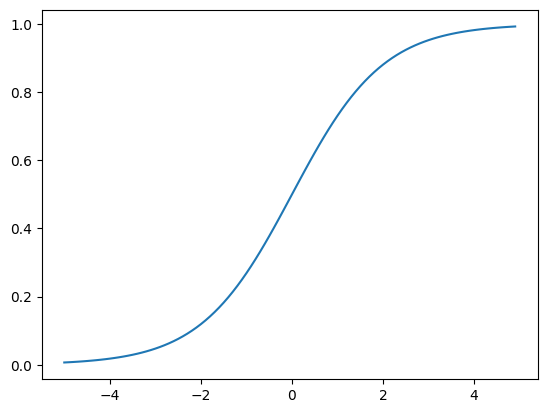

In [179]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.detach().numpy())
plt.show()

<ipython-input-180-09e9f5cd6857>:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5., 5., 0.1)


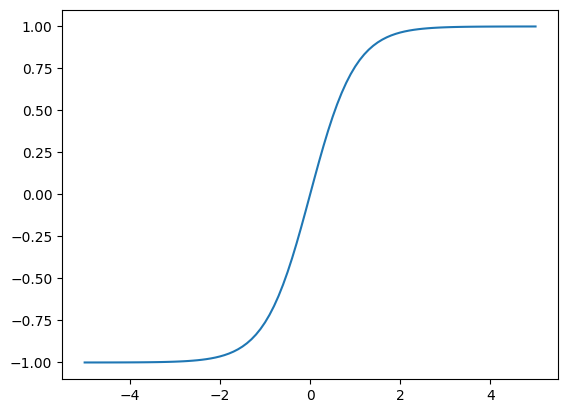

In [180]:
import torch
import matplotlib.pyplot as plt

x = torch.range(-5., 5., 0.1)
y = torch.tanh(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

<ipython-input-181-5bfd3c007827>:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5., 5., 0.1)


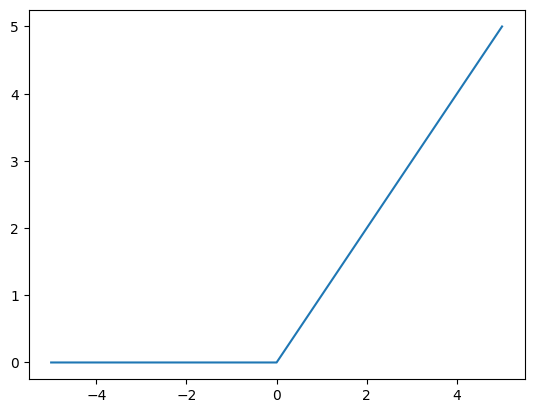

In [181]:
import torch
import matplotlib.pyplot as plt
relu = torch.nn.ReLU()

x = torch.range(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

<ipython-input-182-247c01d933d6>:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5., 5., 0.1)


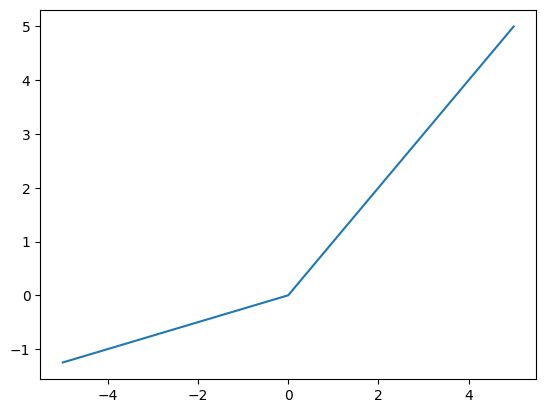

In [182]:
import torch
import matplotlib.pyplot as plt

prelu = torch.nn.PReLU(num_parameters=1)

x = torch.range(-5., 5., 0.1)
y = prelu(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

In [183]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[-2.0260, -2.0655, -1.2054]])
tensor([[0.2362, 0.2271, 0.5367]])
tensor([1.])


In [184]:
import torch
import torch.nn as nn

mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(1.6031, grad_fn=<MseLossBackward0>)


In [185]:
import torch
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
print(loss)

tensor(2.5949, grad_fn=<NllLossBackward0>)


In [186]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss)

tensor([[0.7411],
        [0.5622],
        [0.8286],
        [0.6569]], grad_fn=<SigmoidBackward0>)
tensor(0.5958, grad_fn=<BinaryCrossEntropyBackward0>)


CLASSIFYING YELP REVIEWS

In [187]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [188]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [189]:
# the vectorizer
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review

        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)

        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)

        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary

        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching

        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

In [190]:
# the dataset
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer.
        Used in the case in the vectorizer has been cached for re-use

        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file

        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json

        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe

        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [191]:
# the model
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features,
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

In [192]:
# training
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [193]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [194]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    # review_csv='data/yelp/reviews_with_splits_full.csv',
    save_dir='model_storage/ch3/yelp/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/vectorizer.json
	model_storage/ch3/yelp/model.pth
Using CUDA: False


In [195]:
# intitialization

if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer


FileNotFoundError: ignored

In [196]:
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

FileNotFoundError: ignored

In [197]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: -1.000
Test Accuracy: -1.00


In [198]:
# Inference
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [199]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review

    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)

    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))

    probability_value = F.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [200]:
test_review = "this is a pretty awesome book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

NameError: ignored

In [201]:
classifier.fc1.weight.shape

AttributeError: ignored

In [202]:
# Sort weights
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

print("====\n\n\n")

# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

AttributeError: ignored